In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import csv
import pandas as pd
import requests
import json
import http
import io
import datetime
from mpl_toolkits.mplot3d import Axes3D

LOBO description: http://fau.loboviz.com/cgidoc/

Name of variables from LOBO: 
- Chemical composition: cdom, conductivity, oxygen,  nitrate, oxygen_sat, salinity, phosphate, pH  
- Physical properties: flourescence, voltage, temperature, turbidity, scattering
- Biological properties: chlorophyll
- Others: depth, temperature, pressure, current_direction

In [2]:
"""
The function below is used for requesting LOBO dataset.
The input of the function is: min_date, max_date, node (by default of "68" - SLE-SF2 station), list of variables (y)
"""
def LOBORequest(min_date, max_date, node, y):
    link = f"http://fau.loboviz.com/cgi-data/nph-data.cgi?min_date={min_date}&max_date={max_date}&y={y}&data_format=text&node={node}"
    receive = requests.get(link)
    
    #Translate the text file (above) into a dataframe
    url_data = receive.content
    file = io.StringIO(url_data.decode('utf-8'))
    
    raw_data = []
    for x in file:
        raw_data.append(x)

    raw_data = [n.replace('\n', '') for n in raw_data]
    raw_data = [n.split('\t') for n in raw_data]

    raw_dataframe = {}
    pdSeries = []

    for index, item in enumerate(raw_data):
        if index == 2:
            for variable in item: 
                raw_dataframe.update({variable:{}})

        final_dataframe = pd.DataFrame(raw_dataframe)
        if index >= 3:
            for index2, value in enumerate(item):
                if index2 == 0: 
                    #Transfer the first text value into date time value
                    item[index2] = datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S')

                if index2 != 0:
                    #Transfer text to float, for example "24.89" to 24.89
                    if value != '':
                        item[index2] = float(value)
                        if float(value) < 0:
                            item[index2] = None
                    else:
                        item[index2] = None

            pdSeries.append(pd.Series(item, index=final_dataframe.columns))
        
    final_dataframe = final_dataframe.append(pdSeries, ignore_index = True)
    #Some date values will show weird integer values, for example in 2018 dataset, at row 903.
    #We want to remove those rows from our dataset
    removed_rows = []
    for index, date in enumerate(final_dataframe['date [EST]']):
        if type(date) == int:
            removed_rows.append(index)
    final_dataframe = final_dataframe.drop(removed_rows)
    return final_dataframe

In [3]:
dataset = LOBORequest(min_date = "20170101" , max_date = "20191231", node = "68", y = "chlorophyll, cdom, phosphate, nitrate, oxygen")

In [4]:
dataset

,date [EST],chlorophyll [ug/L],CDOM [QSDE],phosphate concentration [uM],nitrate [uM],dissolved oxygen [ml/l]
0,2017-01-01 00:00:00,4.21,53.18,2.25,16.8,1.32
1,2017-01-01 01:00:00,4.26,52.45,1.97,13.4,1.06
2,2017-01-01 02:00:00,6.11,52.31,1.87,12.3,0.98
3,2017-01-01 03:00:00,5.19,51.62,1.70,15.9,0.88
4,2017-01-01 04:00:00,4.63,51.97,1.55,15.0,1.09
...,...,...,...,...,...,...
25946,2019-12-31 19:00:00,3.60,30.35,8.64,79.8,4.72
25947,2019-12-31 20:00:00,3.79,30.32,8.52,74.8,4.77
25948,2019-12-31 21:00:00,3.71,30.48,8.40,75.0,4.74
25949,2019-12-31 22:00:00,3.50,30.70,8.30,74.2,4.53


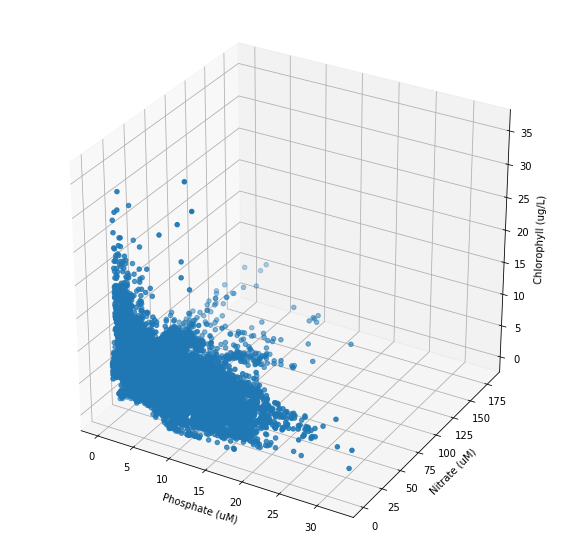

In [9]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset["phosphate concentration [uM]"], dataset["nitrate [uM]"], dataset["chlorophyll [ug/L]"])
ax.set_xlabel('Phosphate (uM)')
ax.set_ylabel('Nitrate (uM)')
ax.set_zlabel('Chlorophyll (ug/L)')
plt.show()

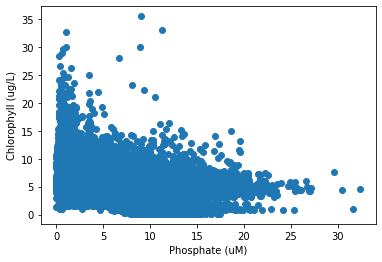

In [10]:
plt.scatter(dataset["phosphate concentration [uM]"], dataset["chlorophyll [ug/L]"])
plt.xlabel('Phosphate (uM)')
plt.ylabel('Chlorophyll (ug/L)')
plt.show()